# Locate images in drive



In [1]:
# %%shell

# # download the Penn-Fudan dataset
# wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# # extract it in the current folder
# unzip PennFudanPed.zip

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/My Drive/bio_research/Code')

images_dir = 'resources/images/segmentation'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


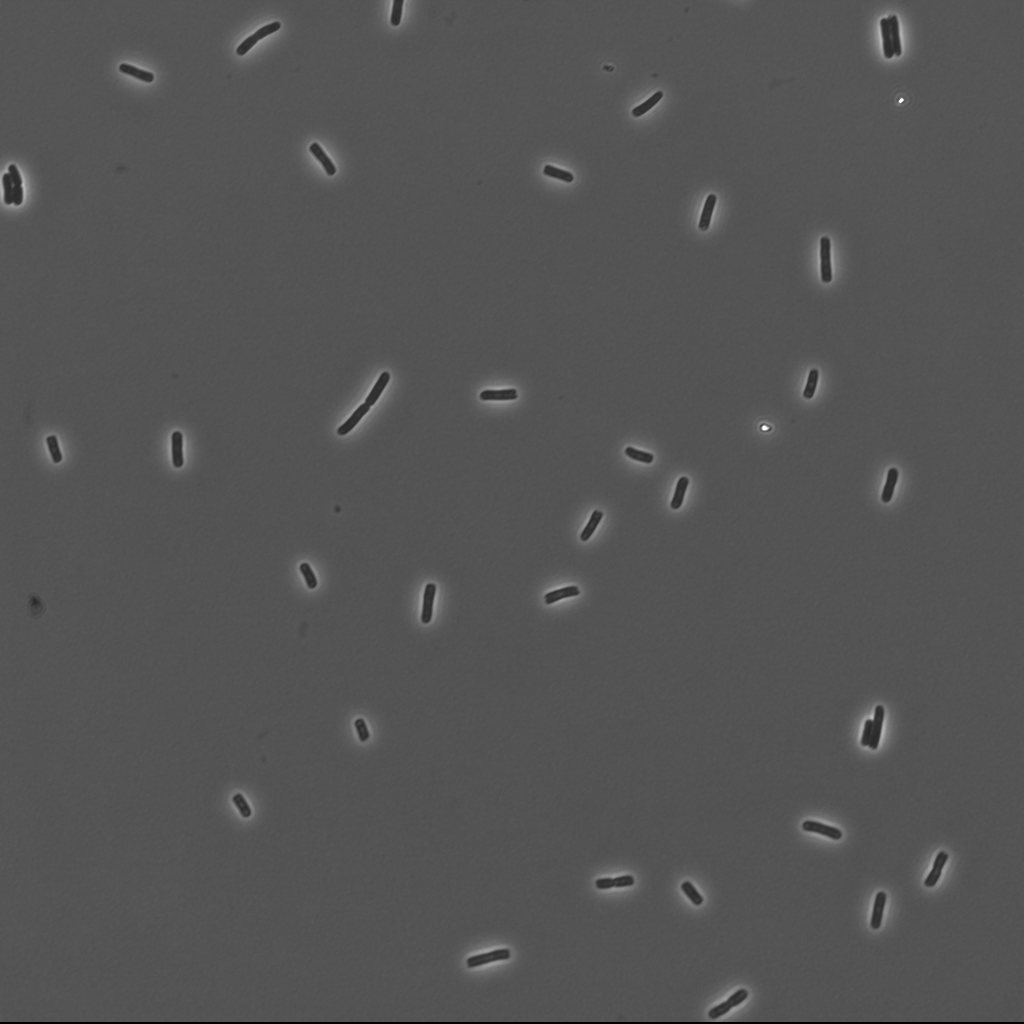

In [2]:
from PIL import Image
import numpy as np
Image.open(os.path.join(images_dir, 'train/images/image_03.tif'))

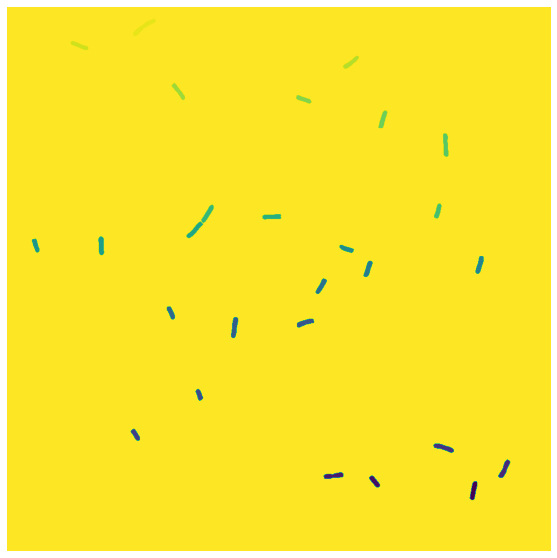

In [3]:
mask = Image.open(os.path.join(images_dir, 'train/masks/mask_03.tif'))
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(mask, cmap='viridis_r');

# Install dependencies

In [4]:
%%shell
pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-r9utlb1l
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-r9utlb1l
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275265 sha256=24661e0ee321083862f68ae7f1f6297e52c6bf323468cdcb5e1892a6a9ee042d
  Stored in directory: /tmp/pip-ephem-wheel-cache-26pf8y9y/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.0
    Uninstalling pycocotools-2.0.0:
      Successfully uninstalled pycocotools-2.0.0


# Define Custom Daaset

In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import math
import cv2


class MicroscopyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path)
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        remove = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            if xmax <= xmin or ymax <= ymin:
                remove.append(i)
                continue
            
            boxes.append([xmin, ymin, xmax, ymax])
            
        if remove:
          masks = np.delete(masks, remove, 0)
          num_objs = len(masks)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [0]:
dataset = MicroscopyDataset(os.path.join(images_dir, 'train'))

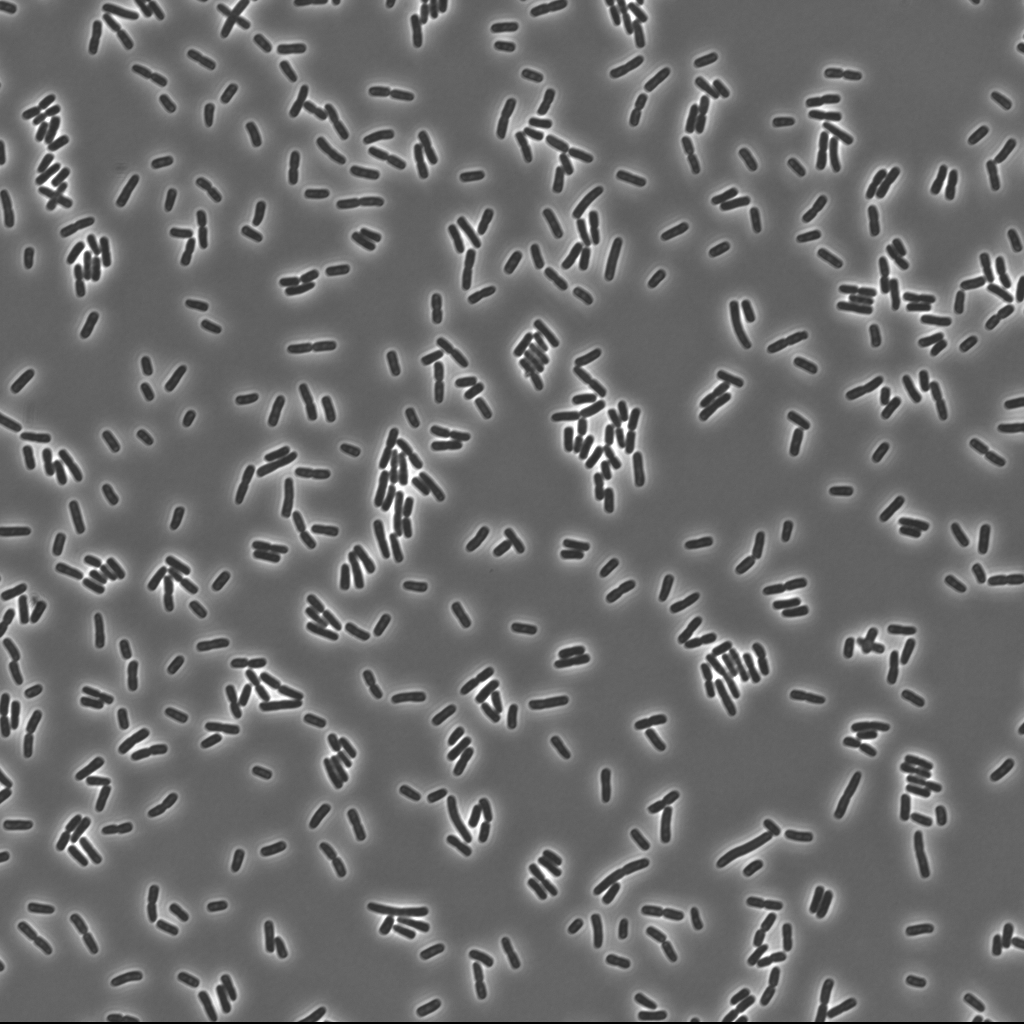

In [7]:
# import matplotlib.pyplot as plt
# plt.imshow(dataset[32][1]['masks'][63], cmap='gray')
# dataset[36]
# verdicts = []
# for i in range(len(dataset)):
#     box = dataset[i][1]['boxes']
#     for j in range(len(dataset[i][1]['boxes'])):
#         verdict = all(b > 0 for b in box[j].tolist())
#         verdicts.append(verdict)
#         print(i, j, ':', verdict)
# print('final verdict:', all(verdicts))
import matplotlib.pyplot as plt

img, target = dataset[32]

img

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

# Defining your model

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
# git clone https://github.com/pytorch/vision.git
# git reset --hard
# git clean -fdxq
# cd vision
# git checkout v0.3.0

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [0]:
# use our dataset and defined transformations
dataset = MicroscopyDataset(os.path.join(images_dir, 'train'), get_transform(train=True))
dataset_test = MicroscopyDataset(os.path.join(images_dir, 'test'), get_transform(train=False))

# split the dataset in train and test set
# torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=5e-3,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [63]:
# let's train it for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()
  
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

# save model at the end
torch.save(model, 'resources/models/pytorch_mask_rcnn.pkl')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch: [0]  [ 0/40]  eta: 0:01:38  lr: 0.000027  loss: 11.2054 (11.2054)  loss_classifier: 0.7874 (0.7874)  loss_box_reg: 0.0367 (0.0367)  loss_mask: 4.3240 (4.3240)  loss_objectness: 5.4800 (5.4800)  loss_rpn_box_reg: 0.5772 (0.5772)  time: 2.4673  data: 2.1392  max mem: 5027
Epoch: [0]  [10/40]  eta: 0:00:23  lr: 0.000283  loss: 1.4548 (4.1164)  loss_classifier: 0.3384 (0.4403)  loss_box_reg: 0.2933 (0.2616)  loss_mask: 0.5437 (1.6283)  loss_objectness: 0.1073 (1.4553)  loss_rpn_box_reg: 0.2378 (0.3309)  time: 0.7929  data: 0.5015  max mem: 5027
Epoch: [0]  [20/40]  eta: 0:00:11  lr: 0.000539  loss: 1.3828 (2.8297)  loss_classifier: 0.2649 (0.4119)  loss_box_reg: 0.3273 (0.2952)  loss_mask: 0.3219 (1.0151)  loss_objectness: 0.0879 (0.7963)  loss_rpn_box_reg: 0.2299 (0.3112)  time: 0.5038  data: 0.2244  max mem: 5027
Epoch: [0]  [30/40]  eta: 0:00:10  lr: 0.000795  loss: 1.2420 (2.3197)  loss_classifier: 0.2644 (0.3711)  loss_box_reg: 0.3095 (0.3003)  loss_mask: 0.2885 (0.7758)  loss_

Now that training has finished, let's have a look at what it actually predicts in a test image

In [64]:
# pick one image from the test set
img, targets = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
# img.numpy().shape
# predict(np.transpose(img.numpy(), (1, 2, 0)), model)
# import matplotlib.pyplot as plt
# plt.imshow(img.numpy()[0], cmap='gray')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [17]:
prediction

[{'boxes': tensor([[ 544.8910,  171.3486,  554.3993,  189.7747],
          [ 362.6318,  596.6067,  378.0560,  620.4580],
          [ 649.2231,  165.6024,  659.5221,  183.5387],
          [ 534.6274,  636.4207,  550.5971,  662.3174],
          [ 494.4048,  393.7075,  502.4747,  419.5741],
          [ 452.2426,  809.1689,  470.8592,  828.8638],
          [ 983.7238,  389.8658,  995.7295,  407.2883],
          [ 424.5045,  518.9718,  437.9371,  535.7122],
          [ 623.3517,  536.7587,  635.9675,  556.5867],
          [ 313.1773,  503.4653,  322.7197,  525.2754],
          [ 400.7493,  492.7754,  410.8183,  506.9423],
          [ 823.3407,  253.0879,  830.7227,  271.1010],
          [ 495.3921,  584.3972,  505.3983,  597.9680],
          [  36.3935,  811.7146,   44.8316,  827.9393],
          [ 156.8860,  334.2942,  164.1923,  353.2819],
          [ 748.5344,  790.0293,  759.5100,  811.7457],
          [ 833.6783,   91.6336,  846.2267,  115.8179],
          [ 161.4586,  490.9869,  173.1

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

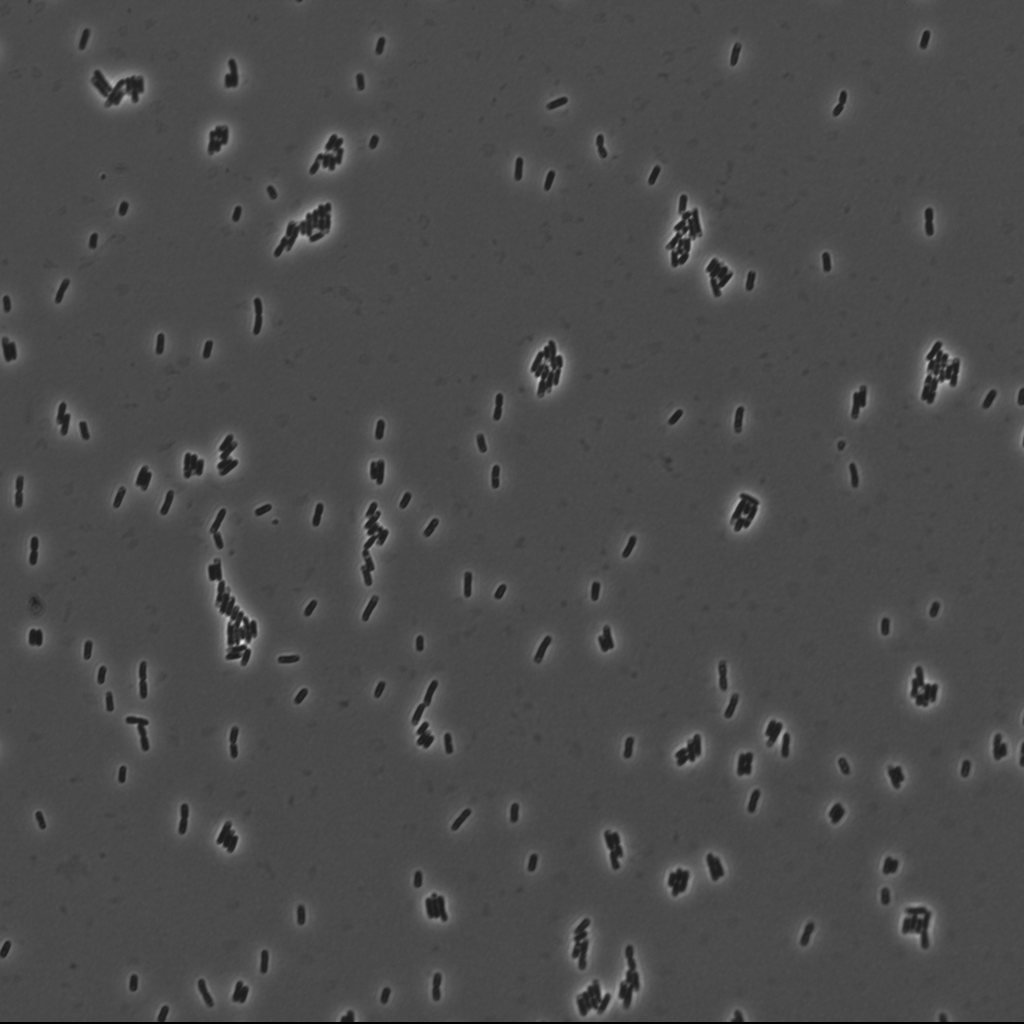

In [18]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

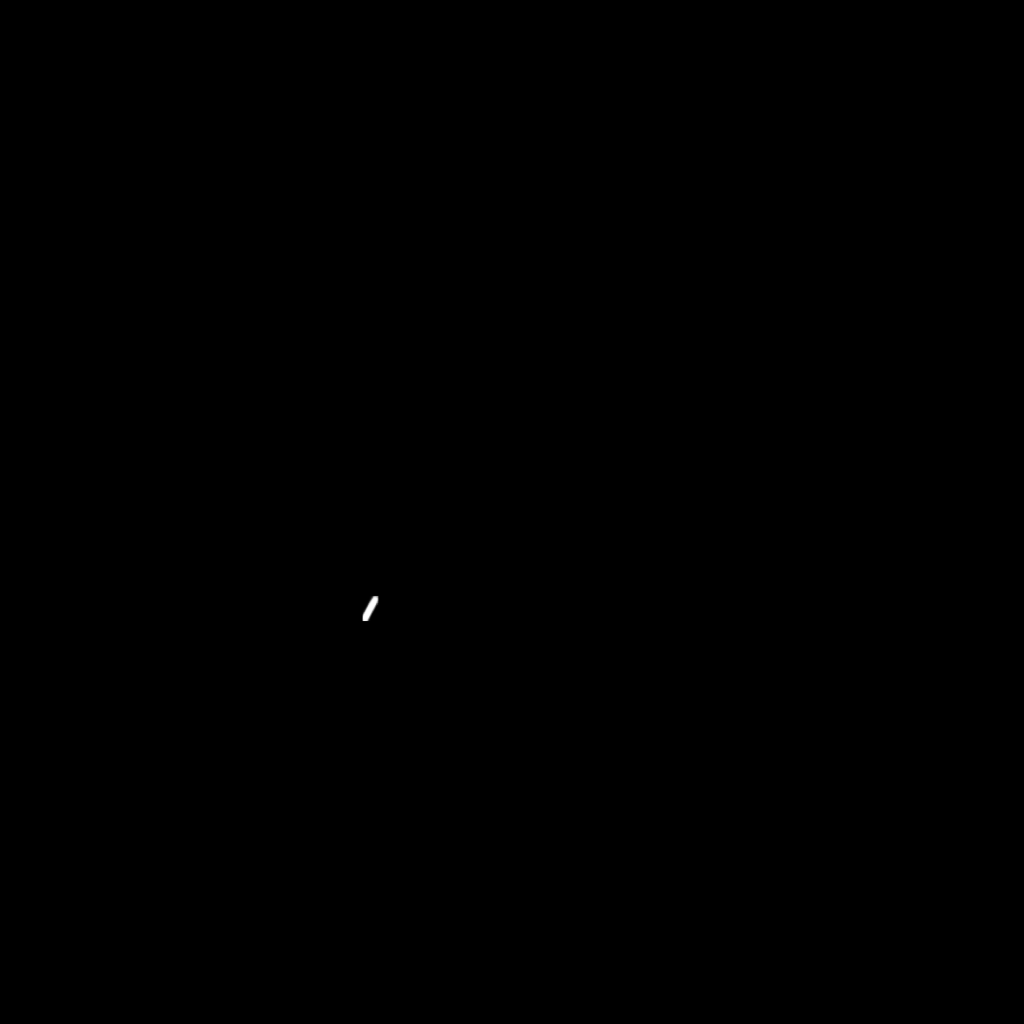

In [20]:
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())

In [0]:
masks = np.squeeze(prediction[0]['masks'].cpu().numpy())

In [0]:
blank = np.zeros_like(masks[0])
for msk in masks:
  # print(np.unique(msk))
  blank[msk > 0.95] = 1

In [0]:
true_full_msk = np.zeros_like(targets['masks'].cpu().numpy()[0])
for msk in targets['masks'].cpu().numpy():
  # print(np.unique(msk))
  true_full_msk[msk == 1] = 1

In [0]:
numpy_img = img.mul(255).permute(1, 2, 0).byte().numpy()

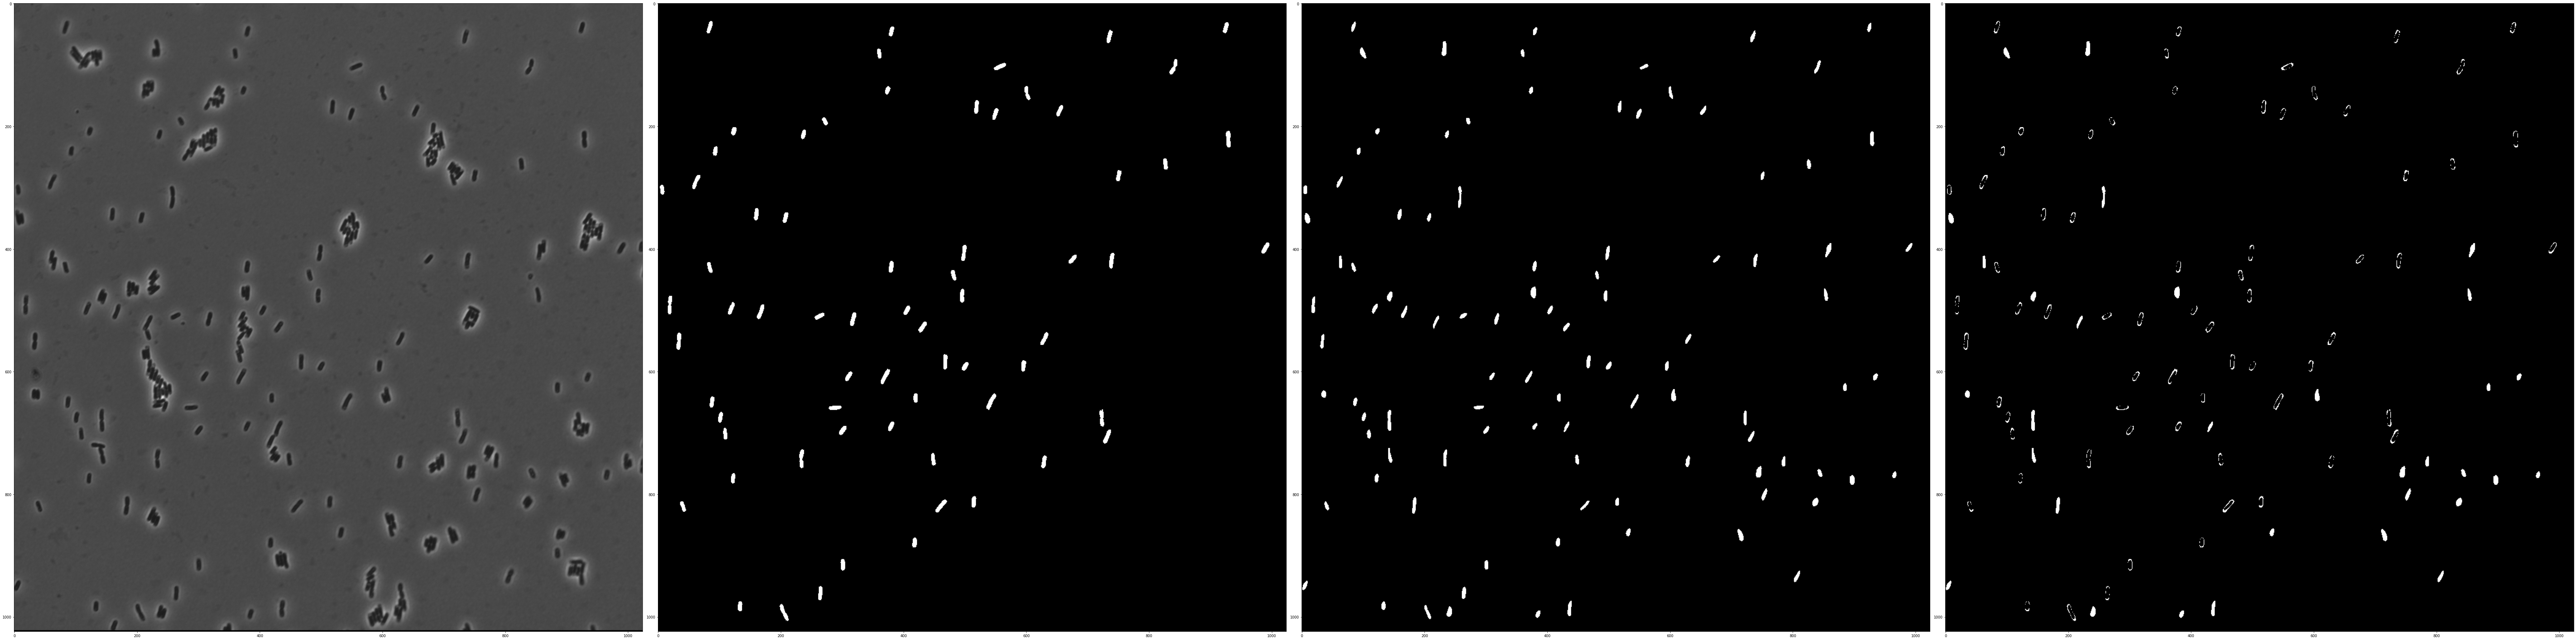

In [69]:
# plt.figure(figsize=(10, 10))
%matplotlib inline
# fixed = numpy_img * np.expand_dims(np.abs(true_full_msk - blank), axis=-1)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(100, 100))
ax1.imshow(numpy_img)
ax2.imshow(true_full_msk, cmap='gray')
ax3.imshow(blank, cmap='gray')
ax4.imshow(np.abs(true_full_msk - blank), cmap='gray')
plt.tight_layout()